We first load some libraries, set some paths and the printing options

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

np.set_printoptions(precision=3, suppress=True, threshold=np.nan)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:2.2f}'.format)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 30

data_dir = os.path.join(os.getcwd(), 'data')

In [2]:
## Load the Test Set
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

# Step 1 - Basic Preprocessing

In the first step we will start to explore the data and preprocess it a little bit. The main data frame is on v2 (this is how it comes from Kaggle), at the end we will save it in its v3, so we can reload it without having to go through this step again. What we do here is removing bad lines, changing the types of the data, removing negative entries, add the shop id to the main frame, add the day_of_the_week/day/month/year from the date, etc.

In [3]:
# Step 1 - Load the Data
df_train = pd.read_csv(os.path.join(data_dir, 'sales_train_v2.csv'))
df_items_and_cats = pd.read_csv(os.path.join(data_dir, 'items-translated.csv'))
df_shops = pd.read_csv(os.path.join(data_dir, 'shops-translated.csv'))

Here are some functions for the first preprocessing.

In [4]:
## Step 1 - Some Functions
def fix_returned_items(df):
	days_with_returns = df[df['item_cnt_day'] < 0]['date']
	nbr_days_with_returns = days_with_returns.value_counts().shape[0]
	nbr_days = df['date'].value_counts().shape[0]
	print(f'\nThere are {nbr_days_with_returns} days with returns out of {nbr_days}.')
	print(f'There are {days_with_returns.shape[0]} returned transactions out of {df_train.index.shape[0]}.')
	study_returned_items_values = False
	if study_returned_items_values:
		sold_vs_returns = []
		for day in days_with_returns.unique():
			df_day_neg = df[(df['date'] == day) & (df['item_cnt_day'] < 0)]
			df_day_pos = df[(df['date'] == day) & (df['item_cnt_day'] > 0)]
			sold_vs_returns.append([df_day_pos['item_price'].dot(df_day_pos['item_cnt_day']), df_day_neg['item_price'].dot(df_day_neg['item_cnt_day'])])
			print([df_day_pos['item_price'].dot(df_day_pos['item_cnt_day']), df_day_neg['item_price'].dot(df_day_neg['item_cnt_day'])])

	remove_returned_items_rows = True
	if remove_returned_items_rows:
		df.drop(df[df['item_cnt_day'] < 0].index, inplace=True)
		df.reset_index(drop=True, inplace=True)
		print(f'Removed rows when items returned')

def fix_negative_prices(df):
	days_with_neg_prices = df[df['item_price'] < 0]['item_price']
	nbr_days_with_neg_prices = days_with_neg_prices.shape[0]
	print(f'\nThere are {nbr_days_with_neg_prices} items with negative prices out of {df.shape[0]}.')

	remove_item_with_neg_price = True
	if remove_item_with_neg_price:
		df.drop(df[df['item_price'] < 0].index, inplace=True)
		df.reset_index(drop=True, inplace=True)
		print(f'Removed rows when item has negative price')

def fix_shops_id(df):
	df['shop_id'] = df['shop_id'].map(dict_duplicated_shops)
	# now we do the trick we talked about while creating the dictionnary, to have a nice range of shops.
	df['shop_id'] = df['shop_id'].map(dict_duplicated_shops_2)

Visualizing the auxilliary dataframe "items and categories". Nothing to say here. We will later add the category_id for each item into the main dataframe, as it is not there.

In [ ]:
# Step 1 - Visualize the df_items_and_cats
df_items_and_cats.head()
df_items_and_cats.info()
df_items_and_cats.describe()

Visualizing the auxilliary dataframe "shops". We observe that there are some duplicated shops name. We thus create a dictionnary to change the id of any duplicated shop with the first time it appears in the list (in the training and test set). Notice that 57 will become 0, 58 will become 1 and 11 will become 10, so we eliminate 11,57, 58. If we later replace 59 with the eliminated 11, then the range will go from 0 to 56 nicely without jumping any shop. We thus create a 2nd dictionnary that will do just this, and apply it after applying the first one.

In [5]:
# Step 1 - Visualize and Preprocess the df_shop
df_shops.head()
df_shops.info()
df_shops.describe()
df_shops[df_shops['shop_name_translated'].duplicated(keep=False)]  # {11:10, 57:0, 58:1}
dict_duplicated_shops = {x:x for x in df_shops['shop_id'].unique()}
dict_duplicated_shops[11] = 10
dict_duplicated_shops[57] = 0
dict_duplicated_shops[58] = 1
dict_duplicated_shops_2 = {x:x for x in range(60)}
dict_duplicated_shops_2[59] = 11

,shop_id,shop_name_translated
0,0,"Yakutsk Ordzhonikidze, 56 francs"
1,1,"Yakutsk TC ""Central"" franc"
2,2,"Adygea Shopping Center ""Mega"""
3,3,"Balashikha TRK ""October-Kinomir"""
4,4,"Volzhsky shopping center ""Volga Mall"""


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
shop_id                 60 non-null int64
shop_name_translated    60 non-null object
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


,shop_id
count,60.00
mean,29.50
std,17.46
min,0.00
25%,14.75
50%,29.50
75%,44.25
max,59.00


,shop_id,shop_name_translated
0,0,"Yakutsk Ordzhonikidze, 56 francs"
1,1,"Yakutsk TC ""Central"" franc"
10,10,Zhukovsky Str. Chkalov 39m
11,11,Zhukovsky Str. Chkalov 39m
57,57,"Yakutsk Ordzhonikidze, 56 francs"
58,58,"Yakutsk TC ""Central"" franc"


Visualizing the main dataframe.

In [ ]:
# Step 1 - Visualize the main df 
df_train.head()
df_train.info()
df_train.describe()

First big preprocessing of the main dataframe. 

We first observe that there are no Null and NA values, and that there are 6 duplicate lines, which we ignore as this is not necessarily a mistake in the dataset (different people could have bought the same day the same items)

We then remove the rows with negative entries for "item_count". There are 1023 days / 1034 that have returned items, with 7356 items returned / 2935849 transactions. This is not that many items. When looking at the total value of the items returned, a typical day would have 10.000$ returned vs 5.000.000$ bought, so 1/500 in value returned. This is not that much, especially that all days are pretty similar in this regard, so we just remove those columns. Ignoring is probably okay too.

We then look at rows with negative prices: there is 1 item with negative price, remove it.

We add the category of the item on main df from the df_items_and_cats datafram, as it was not in the main dataframe.

We change the id's of duplicated shops and merge them together. For this we use the dictionnary previously created.

We also add the day_of_week, day, month and year, as well as remove the date in string format.

We downcast the types from int64 to int16/int8 and float64 to float32, saving memory from 167+MB to 64MB, that's awesome. We create a dictionnary for the types, so from now on we open the file with the correct dtypes, following the dictionnary.

Finally, we save this preprocessed dataframe as v3, so we could just load it without having to go through this preprocessing again.

In [6]:
### Step 1 - Process the main df (v2 -> v3) and test set
#print(df_train.info())

# Check for Null, NA and duplicates
df_train.isnull().sum() #no null
df_train.isna().sum() # no na
df_train[df_train.duplicated(keep=False)]

# fix negative values
fix_returned_items(df_train)
fix_negative_prices(df_train)

# add category_id column
dict_of_items = dict(zip(df_items_and_cats['item_id'], df_items_and_cats['item_category_id']))
df_train['item_category'] = df_train['item_id'].map(dict_of_items)

# Fix duplicated shops
fix_shops_id(df_train)
fix_shops_id(df_test)

# change date in (year, month, day, day of the week)
df_train['date'] = pd.to_datetime(df_train['date'], format="%d.%m.%Y")
df_train['day'] = df_train['date'].dt.day.astype(np.int8)
df_train['month'] = df_train['date'].dt.month.astype(np.int8)
df_train['year'] = df_train['date'].dt.year.astype(np.int16)
df_train['day_of_week'] = df_train['date'].dt.day_name()
df_train.drop(columns = 'date', inplace = True)

# downcast types
print(df_train.info())
#for col in df_train.columns:
#    print(col, df_train[col].max())
df_train['date_block_num'] = df_train['date_block_num'].astype(np.int8)
df_train['shop_id'] = df_train['shop_id'].astype(np.int8)
df_train['item_category'] = df_train['item_category'].astype(np.int8)
df_train['item_id'] = df_train['item_id'].astype(np.int16)
df_train['item_price'] = df_train['item_price'].astype(np.float32)
#df_train['item_cnt_day'].unique() # seems to all be int
df_train['item_cnt_day'] = df_train['item_cnt_day'].astype(np.int16)

print(df_train.info())
df_train.to_csv(os.path.join(data_dir, 'sales_train_v3.csv'), index=False)
df_test.to_csv(os.path.join(data_dir, 'test_v3.csv'), index=False)

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76961,05.01.2013,0,54,20130,149.00,1.00
76962,05.01.2013,0,54,20130,149.00,1.00
1435365,23.02.2014,13,50,3423,999.00,1.00
1435367,23.02.2014,13,50,3423,999.00,1.00
1496765,23.03.2014,14,21,3423,999.00,1.00
1496766,23.03.2014,14,21,3423,999.00,1.00
1671872,01.05.2014,16,50,3423,999.00,1.00
1671873,01.05.2014,16,50,3423,999.00,1.00
1866322,12.07.2014,18,25,3423,999.00,1.00
1866340,12.07.2014,18,25,3423,999.00,1.00



There are 1023 days with returns out of 1034.
There are 7356 returned transactions out of 2935849.
Removed rows when items returned

There are 1 items with negative prices out of 2928493.
Removed rows when item has negative price
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928492 entries, 0 to 2928491
Data columns (total 10 columns):
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
item_category     int64
day               int8
month             int8
year              int16
day_of_week       object
dtypes: float64(2), int16(1), int64(4), int8(2), object(1)
memory usage: 167.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928492 entries, 0 to 2928491
Data columns (total 10 columns):
date_block_num    int8
shop_id           int8
item_id           int16
item_price        float32
item_cnt_day      int16
item_category     int8
day               int8
month             int8
year              int16

# Step 2 : Data Exploration and Feature engineering

The initial preprocessing of the data has been done and we will explore it and try to get an edge. We load the main dataframe in its v3, which is exactly the v2 dataframe preprocessed as above. This is in case we want to skip ahead the above preprocessing. In this step we will remove outliers, look at outdated items and set their sale to 0 in the test set, etc.

In [ ]:
## Step 2 - Load the Data (v3 =  v2 processed, jump here and skip previous preprocessing)
dict_types_v3 = {'date_block_num':np.int8, 'shop_id':np.int8, 'item_category':np.int8, 'item_id': np.int16, 'item_price':np.float32, 'item_cnt_day':np.int16, 'day':np.int8, 'month':np.int8, 'year': np.int16}
df_train = pd.read_csv(os.path.join(data_dir, 'sales_train_v3.csv'), dtype = dict_types_v3)
df_test = pd.read_csv(os.path.join(data_dir, 'test_v3.csv'), dtype = dict_types_v3)
df_train.info()
df_test.info()

Visualizing the Test set. Observe that not all shops and not all items from the training set are to be predicted in the test set. Moreover, the test set has 214200 entries, which is 42 shops * 5100 item types. Conversly, notice that there are 363 new items in the test set (but no new shops), so we will set their sales to 0 as we can't guess any better. For this we create a 'pred_0' column in the test set, and mark those items down in there, to set their sales to 0 after the prediction

In [7]:
# Step 2 - Visualize the test df 
df_test.head()
df_test.info()
df_test.describe()

print(f'''There are {len(df_test['shop_id'].unique())} represented shops in the test set, over {len(df_train['shop_id'].unique())} total shops in the training set''')
print(f'''There are {len(df_test['item_id'].unique())} represented items in the test set, over {len(df_train['item_id'].unique())} total items in the training set''')
print(f'''There are {len(set(df_test['shop_id'].unique()) - set(df_train['shop_id'].unique()))} shops in the test set that are not in the training set''')
new_items_id = set(df_test['item_id'].unique()) - set(df_train['item_id'].unique())
print(f'''There are {len(new_items_id)} items id in the test set (over the whole {len(df_test['item_id'].unique())} number of item ids) that are not in the training set''')

df_test['pred_0'] = np.nan
df_test.loc[df_test[df_test['item_id'].isin(new_items_id)].index, 'pred_0'] = 0
df_test.to_csv(os.path.join(data_dir, 'test_v4.csv'), index=False)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-null int64
dtypes: int64(3)
memory usage: 4.9 MB


,ID,shop_id,item_id
count,214200.00,214200.00,214200.00
mean,107099.50,27.79,11019.40
std,61834.36,17.33,6252.64
min,0.00,0.00,30.00
25%,53549.75,12.00,5381.50
50%,107099.50,27.00,11203.00
75%,160649.25,44.00,16071.50
max,214199.00,56.00,22167.00


There are 42 represented shops in the test set, over 57 total shops in the training set
There are 5100 represented items in the test set, over 21804 total items in the training set
There are 0 shops in the test set that are not in the training set
There are 363 items id in the test set (over the whole 5100 number of item ids) that are not in the training set


We now explore the number of sales per item every month. Plotting the total number of sales per month should indicate which months sell the most total of items. We see that month 12 and 24 sell the most, these are December 2013 and 2014, cleary correlated with Christmas.

date_block_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


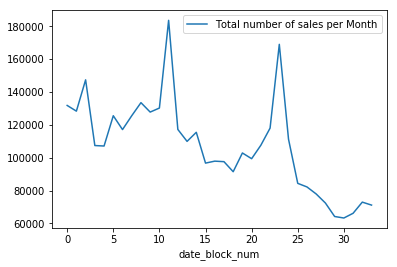

In [8]:
# Step 2 - Visualizing the total number of sales per month
df_sales_per_item = df_train.pivot_table(index = 'item_id', columns = 'date_block_num', values = 'item_cnt_day', aggfunc=np.sum, fill_value=0)
df_sales_per_item.head()
df_sales_per_item.sum(axis=0).plot(legend=True, label='Total number of sales per Month')

Doing a scalar product with the price of each item, we can see how much value was sold everyday in total. We can see an important difference with the number of items sold: the curve is cyclic but the trend is horizontal, v.s. cyclic with downward trend for the number of items sold. This means that even though we sell less and less items, the total value does not decrease, which can be interpreted by the fact that more expensive items are sold. Also, notice the scale where there is a factor of 10^8 to multiply by. ---> Ultimately I'm not doing anything with this info though...

date_block_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,58.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8980.00,0.00,0.00,4490.00,4490.00,4490.00,4490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,58.00,0.00,0.00,58.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,58.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,58.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


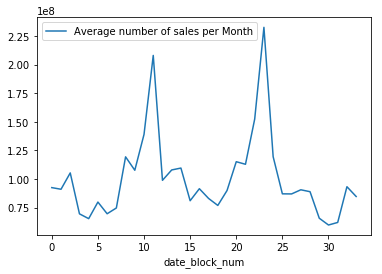

In [9]:
# Step 2 - Visualizing the total value (in money) of sales per month
df_train['value'] = df_train['item_cnt_day'].multiply(df_train['item_price'])
df_sales_per_item_value = df_train.pivot_table(index = 'item_id', columns = 'date_block_num', values = 'value', aggfunc=np.sum, fill_value=0)
df_sales_per_item_value.head()
df_sales_per_item_value.sum(axis=0).plot(legend=True, label='Average number of sales per Month')

Let's now see if some items have not been sold in the last 12 months. These items are most likely outdated and will not sell anymore and we can thus predict 0 for them. We see that there are 9634 item_id's that have not sold out of 21804 total, and that 3696 unique items (not item_ids) out of the 214200 total items from the test set are outdated. This is just under 2% of the test set, where we can manually set the sales to 0 after prediction. For this, we will reuse the column labeled 'pred_0' and mark those items down (and set their sales to 0 after the prediciton).

In [10]:
# Step 2 - search for outdated items
outdated_items = df_sales_per_item[df_sales_per_item.iloc[:,-12:].sum(axis=1) < 1].index
print(f'Outdated item ids in training set : {len(outdated_items)} / {len(df_sales_per_item.index)}')
print(f'''Outdated item ids in test set : {len([1 for x in df_test['item_id'].unique() if x in outdated_items])} / {len(df_test['item_id'].unique())}''')
print(f'''Outdated total items in test set : {df_test['item_id'].isin(outdated_items).sum()} / {len(df_test['item_id'].index)}''')

# now creating the column in the test set in order to set the prediction of those to 0 at the end
df_test.loc[df_test[df_test['item_id'].isin(outdated_items)].index,'pred_0'] = 0
df_test.to_csv(os.path.join(data_dir, 'test_v4.csv'), index=False)

Outdated item ids in training set : 9634 / 21804
Outdated item ids in test set : 88 / 5100
Outdated total items in test set : 3696 / 214200


We will now remove some outliers. 
Looking at the distribution of the number of items sold per transaction, we can remove the outliers > 800, and we see that there are only two of them. The distribution is way better without these 2 outliers.
Similarly, we exlude the one outlier with price around 300000, and replot, the distribution looks nice without it.

In [ ]:
# Step 2 - remove some outliers
print('Quantity of items sold per transaction.')
_ = plt.boxplot(df_train['item_cnt_day'])
plt.show()
print('Quantity of items sold per transaction after removing outliers.')
df_train_no_out = df_train.query('item_cnt_day < 800')
_ = plt.boxplot(df_train_no_out['item_cnt_day'])
plt.show()

print('Price of items.')
_ = plt.boxplot(df_train_no_out['item_price'])
plt.show()
print('Price of items after removing outliers.')
df_train_no_out_2 = df_train_no_out.query('item_price< 100000')
_ = plt.boxplot(df_train_no_out_2['item_price'])

df_train = df_train_no_out_2

In [ ]:
df_train.head()